In [1]:
import sys
sys.path.append('/home/sjhong/WSI_tile_sampling_framework/')
import os
import numpy as np
import openslide
from Tiling import TileSampler
from ForegroundMasking import ForegroundMasker
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [4]:
class PatchDataset(Dataset):
    def __init__(self, img_path, transform = None, patch_size=448, overlap = 0, start= None, end = None, is_normalized = False):
        super(PatchDataset, self).__init__()
        self.img_path = img_path
        self.slide = openslide.OpenSlide(self.img_path)

        self.masker = ForegroundMasker()
        self.tiler = TileSampler(
            tile_size= patch_size,
            dimensions= self.slide.dimensions,
            overlap= overlap,
            min_tiles = 5,
            downscale_factor = self.slide.level_downsamples[-1]
        )
        
        self.is_normalized = is_normalized
        self.patch_size = patch_size 
        self.start = start
        self.end = end
        self.roi_margin = overlap
        self.coords = self._get_patches()
        self.transform = transform
        
    def compute_foreground_mask(self, image):
        """
        Computes the foreground mask using your get_foreground function.
        
        Parameters:
            image (np.ndarray): Input thumbnail image.
            
        Returns:
            mask (np.ndarray): Foreground mask.
        """
        foreground,mask = self.masker.get_foreground(image, self.is_normalized)
        return foreground, mask
    
    def set_roi(self, start_xy, end_xy):
         
        self.start = tuple(map(int, start_xy))
        self.end   = tuple(map(int, end_xy))

    def _filter_coords_by_rect(self, coords):
        """
        coords: list[tuple[int,int]] 또는 (N,2) array (각각 타일의 좌상단 (x,y))
        return: 동일 포맷의 필터링된 coords
        """
        if self.start is None or self.end is None:
            return coords  # ROI 미설정 시 그대로 반환

        # 직사각형 경계 정규화 (start/end 순서 상관없도록)
        x0 = min(self.start[0], self.end[0]) - self.roi_margin
        y0 = min(self.start[1], self.end[1]) - self.roi_margin
        x1 = max(self.start[0], self.end[0]) + self.roi_margin
        y1 = max(self.start[1], self.end[1]) + self.roi_margin

        # 벡터화
        arr = np.asarray(coords, dtype=np.int64)  # shape (N,2) -> [x,y]
        xs, ys = arr[:, 0], arr[:, 1]
        
        '''
        if self.roi_mode == "origin":
            keep = (xs >= x0) & (xs <= x1) & (ys >= y0) & (ys <= y1)

        elif self.roi_mode == "fully_inside":
            # 타일의 우하단이 ROI 안에 있어야 함
            xe = xs + self.tile_size
            ye = ys + self.tile_size
            keep = (xs >= x0) & (ys >= y0) & (xe <= x1) & (ye <= y1)
        else:
            raise ValueError(f"Unknown roi_mode: {self.roi_mode}")
        
        '''
        xe = xs + self.patch_size
        ye = ys + self.patch_size
        keep = (xs >= x0) & (ys >= y0) & (xe <= x1) & (ye <= y1)
        kept = arr[keep]
        # 원래 입력이 list[tuple]이었다면 동일 형태로 반환
        if isinstance(coords, list):
            return [tuple(xy) for xy in kept.tolist()]
        return kept

    def sample_tiles(self, mask):
        """
        Calls the tiling function to sample tile coordinates from the slide using the mask.
        
        Parameters:
            slide: The whole-slide image object.
            mask (np.ndarray): Foreground mask.
            
        Returns:
            coords: List of tile starting coordinates (which are also saved to an HDF5 file).
        """
        # get_tile (from Tiling.py) is assumed to save the coordinates to an HDF5 file.
        #coords,metadata = self.tiler.get_tile(slide, mask,imgname,scaler)
        coords = self.tiler.get_tile(mask)
        if self.start is not None and self.end is not None:
            coords = self._filter_coords_by_rect(coords)
            
        return coords
         
    def _get_patches(self):
        thumbnail = np.array(self.slide.get_thumbnail(self.slide.level_dimensions[-1]))
        _, mask = self.compute_foreground_mask(thumbnail)
        coords = self.sample_tiles(mask)
        
        return coords

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        x, y = self.coords[idx]
        image = self.slide.read_region((x,y),0,(self.patch_size,self.patch_size)).convert('RGB')
        if self.transform is not None:
            transformed_img = self.transform(image=np.array(image))
        else:
            transformed_img = np.array(image)
        return transformed_img, [x, y]

In [5]:
wsi_path = '/home/nas2_fast/Data/Pathology_project/KBSMC/wsi/1-028_08.svs'
dataset = PatchDataset(wsi_path)

2025-10-20 13:02:21,260 - INFO - Template loaded from: templates/tcga_brca_template.json
2025-10-20 13:02:21,261 - INFO - Template info: Created 2025-06-10T16:18:14.300234, Reference Hue=155.6


In [2]:
from histoplus.helpers.tissue_detection import detect_tissue_on_wsi
wsi_path = '/home/nas2_fast/Data/Pathology_project/KBSMC/wsi/1-028_08.svs'

In [21]:
tissue_coords, dz_level = detect_tissue_on_wsi(openslide.OpenSlide(wsi_path))

2025-10-20 13:38:10.451 | INFO     | histoplus.helpers.tiling.optimal_mpp:get_tiling_slide_level:149 - 8.3688 is the closest available MPP to the one requested (8.0). Minimal MPP of the slide is 0.261525.
2025-10-20 13:38:10.453 | INFO     | histoplus.helpers.tiling.optimal_mpp:get_tiling_slide_level:149 - 0.52305 is the closest available MPP to the one requested (0.5). Minimal MPP of the slide is 0.261525.
2025-10-20 13:38:22.462 | INFO     | histoplus.helpers.tissue_detection.core:detect_tissue_on_wsi:80 - Found 19670 tiles with Otsu's threshold.


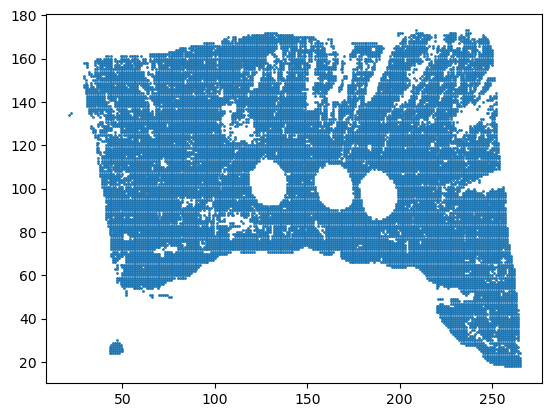

In [24]:
xs = tissue_coords[:,0]
ys = tissue_coords[:,1]
plt.scatter(xs,ys, s=1)
plt.show()

In [8]:
dz_level

16

In [11]:
tissue_coords.shape

(19670, 2)

In [3]:
tissue_coords, dz_level = detect_tissue_on_wsi(openslide.OpenSlide(wsi_path), base_mpp =0.25, matter_threshold = 0.1)
tissue_coords.shape

2025-10-20 16:50:52.101 | INFO     | histoplus.helpers.tiling.optimal_mpp:get_tiling_slide_level:149 - 8.3688 is the closest available MPP to the one requested (8.0). Minimal MPP of the slide is 0.261525.
2025-10-20 16:50:52.103 | INFO     | histoplus.helpers.tiling.optimal_mpp:get_tiling_slide_level:149 - 0.261525 is the closest available MPP to the one requested (0.25). Minimal MPP of the slide is 0.261525.
2025-10-20 16:50:58.211 | INFO     | histoplus.helpers.tissue_detection.core:detect_tissue_on_wsi:80 - Found 61881 tiles with Otsu's threshold.


(61881, 2)

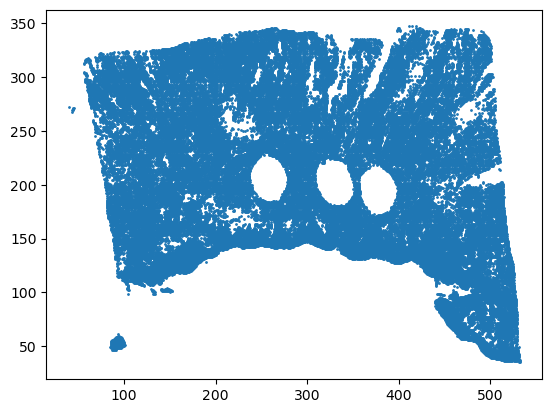

In [26]:
xs = tissue_coords[:,0]
ys = tissue_coords[:,1]
plt.scatter(xs,ys, s=1)
plt.show()

In [4]:
from histoplus.helpers.segmentor import CellViTSegmentor
from histoplus.extract import extract

/home/sjhong/miniconda3/envs/cellvit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
INFERENCE_IMAGE_SIZE = 588
thres = 0.1

In [6]:
segmentor = CellViTSegmentor.from_histoplus(
    mpp=0.25,
    mixed_precision=True,                 # GPU AMP 사용 권장
    inference_image_size=588,
)

In [7]:
# Process a whole slide image
results = extract(
    slide=openslide.OpenSlide(wsi_path),
    coords=tissue_coords,
    deepzoom_level=dz_level,
    segmentor=segmentor,
    batch_size= 4, # 786 -> 32
) 

2025-10-20 16:51:15.650 | INFO     | histoplus.helpers.tiling.optimal_mpp:get_tiling_slide_level:149 - 0.261525 is the closest available MPP to the one requested (0.25). Minimal MPP of the slide is 0.261525.


In [8]:
output_dir = './output/1_028_08/'
os.makedirs(output_dir, exist_ok = True)
json_path = f"{output_dir}/seg_{wsi_path.split('/')[-1][:-4]}_{INFERENCE_IMAGE_SIZE}_{thres}.json"
results.save(json_path)
print(f"OK → {json_path}")

OK → ./output/1_028_08//seg_1-028_08_588_0.1.json


In [2]:
json_path = './output/1_028_08//seg_1-028_08_588_0.1.json'

In [3]:
import json
# JSON 로딩(여러 파일이면 순차 로딩 + 레코드 합치기)
with (open(json_path, "r", encoding="utf-8") if not json_path.endswith(".gz") else __import__("gzip").open(json_path, "rt", encoding="utf-8")) as f:
    data = json.load(f, parse_float=float)

In [4]:
zx, zy = (20450, 43558)
w, h = 11434, 13208

In [5]:
x0, y0 = (20450,43558)
x1, y1 = (31436, 56318)
w = x1-x0
h= y1-y0
w, h

(10986, 12760)

In [6]:
from draw_utils import *
from openslide.deepzoom import DeepZoomGenerator

In [ ]:
tile_size = 448
wsi_path = '/home/nas2_fast/Data/Pathology_project/KBSMC/wsi/1-028_08.svs'
# ── 사용 예 ───────────────────────────────────────────────────
slide = openslide.OpenSlide(wsi_path)
dz = DeepZoomGenerator(slide, tile_size=tile_size, overlap=0, limit_bounds=False)
lvl = 16
# x0, y0 = 72931, 28727 # 좌측 상단 좌표
# w, h   = 8465, 2604

# (A) 낱개 타일 리스트
tiles = tiles_covering_base_rect(slide, dz, lvl, x0, y0, w, h,
                                 tile_size=tile_size, overlap=0, return_spans=False)
if len(tiles) == 1:
    print("I founded this tile:",tiles[0])
    tile = tiles[0]
else:
    print(f"tile count: {len(tiles)}")
    print("first 10:", tiles[:10])  # (level, tx, ty)
    
found_tiles = [
    t for t in data.get("cell_masks", [])
    if (int(t.get("x", -1)), int(t.get("y", -1))) in tiles
]
if found_tiles:
    print(found_tiles[0])
    print(f"총 {len(found_tiles)}개 tile dict 매칭")

    # cell_type = ['Cancer cell', 'Fibroblasts', 'Macrophages', 'Lymphocytes', 'Apoptotic Body', 'Neutrophils']
    roi_comment = f"ROI: x0={x0}, y0={y0}, width={w}, height={h}"
    # cell_type = ['a']
    annot_path = f"./annotation/histo_{wsi_name}_588_0.1.xml"

    tiles_to_asap_xml(
        wsi_path=wsi_path,
        tiles=found_tiles,                   # 3k 타일 dict 리스트
        xml_out_path=annot_path,
        color_map=COLOR_MAP,
        roi_comment = roi_comment,
        contained = list(COLOR_MAP.keys()),
        max_workers=45,                 # 코어에 맞게 조정
    )
else:
    print("NO tiles founded.")

tile count: 210
first 10: [(22, 48), (23, 48), (24, 48), (25, 48), (26, 48), (27, 48), (28, 48), (29, 48), (30, 48), (31, 48)]
NO tiles founded.


: 

In [14]:
len(found_tiles)

0

In [ ]:
img, (x,y) = dataset[0]

In [28]:
from torchvision.transforms import ToTensor

In [29]:
to_tensor = ToTensor()

In [33]:
sample_inp = to_tensor(img).unsqueeze(0)

In [38]:
segmentor.forward(sample_inp)

AssertionError: Caught AssertionError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/sjhong/miniconda3/envs/cellvit/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 99, in _worker
    output = module(*input, **kwargs)
  File "/home/sjhong/miniconda3/envs/cellvit/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/sjhong/miniconda3/envs/cellvit/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/sjhong/segmentation/histoplus/histoplus/helpers/nn/cellvit/model.py", line 178, in forward
    out_dict["np"] = self.np_branch(z[-1], n)
  File "/home/sjhong/miniconda3/envs/cellvit/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/sjhong/miniconda3/envs/cellvit/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/sjhong/segmentation/histoplus/histoplus/helpers/nn/cellvit/decoder.py", line 236, in forward
    b1 = downscale_map(b1, self.upsampled_size, self.target_size)
  File "/home/sjhong/segmentation/histoplus/histoplus/helpers/nn/cellvit/decoder.py", line 424, in downscale_map
    assert output_shape == desired_shape, (
AssertionError: Shapes of predicted maps are (512, 512). It should be (224, 224)!
